# Virtual Distillation
We check the behavior under some noise models.

In [1]:
import qutip

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt

N = 8 # Total dimension of the space. We will use three copies so N^3 size matrices

### Initial noisy Fock state

Kraus operators $\hat A_k(t)=\dfrac{(1-e^{-\kappa t})^{k/2}}{\sqrt{k!}}e^{-\kappa \hat n t/2}\hat a^k$.
$$\hat\rho(t)=\sum_{k=0}^\infty\hat A_k(t)\hat\rho_0\hat A_k(t)^\dagger$$

with $\rho_0=\ket n\bra n$

In [3]:
n = 2
kappa = 0.4

nb_samples = 25
t_list = np.linspace(0,1,nb_samples)

def kraus_op(k, t):
    # returns Kraus operator as defined above
    op = (-kappa*t/2*qutip.num(N)).expm()
    op = op * qutip.destroy(N)**k
    prefactor = (1-np.exp(-kappa*t))**(k/2)/(np.sqrt(math.factorial(k)))
    return prefactor * op

# Creation of the states
rho_list = []
for t in t_list:
    rho_0 = qutip.fock_dm(N,n)
    rho = qutip.Qobj(np.zeros((N,N))) # 0 matrix
    for k in range(n+1): # not useful to go beyond n
        kraus = kraus_op(k, t)
        rho = rho + kraus * rho_0 * kraus.dag()
    rho_list.append(rho)

Text(0.5, 1.0, 't=1.000')

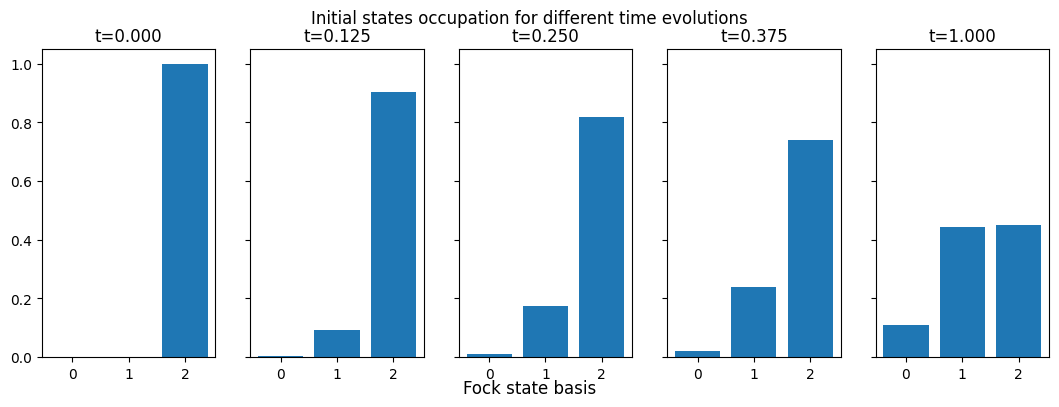

In [4]:
nb_plots = 4
f, axes = plt.subplots(1, nb_plots+1, sharey=True, figsize=(13,4))
f.suptitle("Initial states occupation for different time evolutions")
f.supxlabel("Fock state basis")
for i in range(nb_plots):
    axes[i].bar(np.arange(n+1),np.abs(np.diag(rho_list[3*i]))[:n+1])
    axes[i].set_title(f't={t_list[3*i]:.3f}')
axes[nb_plots].bar(np.arange(n+1),np.abs(np.diag(rho_list[nb_samples-1]))[:n+1])
axes[nb_plots].set_title(f't={t_list[nb_samples-1]:.3f}')

### Virtual Distillation protocol
We perform the protocol for $M=3$ copies of the noisy input state using the diagonalizing method. This is done by applying three successive beam splitter operations on the 3-mode system, resulting in the following gate:
$$\hat{\mathcal F}_3=e^{\frac{i\pi}4(\hat a_1^\dagger \hat a_2+\hat a_2^\dagger \hat a_1)}e^{i\arcsin{(\frac1{\sqrt3})}(\hat a_3^\dagger \hat a_2+\hat a_2^\dagger \hat a_3)}e^{\frac{i\pi}4(\hat a_3^\dagger \hat a_1+\hat a_1^\dagger \hat a_3)}$$

We try adding some coherent error on the angle of the beam splitter, modelized by a Gaussian distribution.

$$\hat{\mathcal F}_3(\varepsilon)=e^{i\left(\frac{\pi}4+\varepsilon_1\right)(\hat a_1^\dagger \hat a_2+\hat a_2^\dagger \hat a_1)}e^{i\left(\arcsin{(\frac1{\sqrt3})}+\varepsilon_2\right)(\hat a_3^\dagger \hat a_2+\hat a_2^\dagger \hat a_3)}e^{i\left(\frac{\pi}4+\varepsilon_3\right)(\hat a_3^\dagger \hat a_1+\hat a_1^\dagger \hat a_3)}$$
with
$$\varepsilon=(\varepsilon_1,\varepsilon_2,\varepsilon_3)\sim \mathcal N(0,\sigma)$$

In [5]:
a1 = qutip.tensor(qutip.destroy(N),  qutip.identity(N), qutip.identity(N))
a2 = qutip.tensor(qutip.identity(N), qutip.destroy(N),  qutip.identity(N))
a3 = qutip.tensor(qutip.identity(N), qutip.identity(N), qutip.destroy(N))
n1 = qutip.tensor(qutip.num(N),  qutip.identity(N), qutip.identity(N))
n2 = qutip.tensor(qutip.identity(N), qutip.num(N),  qutip.identity(N))
n3 = qutip.tensor(qutip.identity(N), qutip.identity(N), qutip.num(N))

def create_F3(sines, noise):
    # takes as input an array with the sines of the three beam splitter angles
    # a perfect F3 corresponds to s1=s3=1/sqrt(2) and s2=1/sqrt(3)
    t1, t2, t3 = np.arcsin(sines) + noise
    bs1 = (1j*t1*(a1.dag()*a2 + a2.dag()*a1)).expm()
    bs2 = (1j*t2*(a3.dag()*a2 + a2.dag()*a3)).expm()
    bs3 = (1j*t3*(a1.dag()*a3 + a3.dag()*a1)).expm()
    return bs1 * bs2 * bs3

# redifining the modes up to global phase (useless)

#left_redef  = (-2j*np.pi/3*n1 - 5j*np.pi/6*n2 ).expm()
#right_redef = (-1j*np.pi/2*n1 - 1j*np.pi/2*n2).expm()

$$n=2$$
$$\kappa=0.4$$
$$\sigma=0.1$$

In [6]:
nb_F_samples = 100

eps_std = 0.1
initial_sin_angles = np.sqrt((1/2,1/3,1/2))
noise_list = np.random.normal(0,eps_std,(nb_F_samples,3))
F_list = []
for (i,noise) in enumerate(noise_list):
    if (i%4==0): print(f"{i+1}/{nb_F_samples}", end=" ")
    F_list.append(create_F3(initial_sin_angles, noise))

1/100 5/100 9/100 13/100 17/100 21/100 25/100 29/100 33/100 37/100 41/100 45/100 49/100 53/100 57/100 61/100 65/100 69/100 73/100 77/100 81/100 85/100 89/100 93/100 97/100 

After applying the diagonalizing gate, we obtain
$$\tilde \rho=\hat{\mathcal F}_3\rho^{\otimes 3}\hat{\mathcal F}_3^\dagger$$
We can then measure $\hat n_1$, $\hat n_2$, $\hat n_3$ and by repeating the experiment retrieve
$$ \operatorname{den}=\left\langle\hat{\mathcal R_3}\right\rangle =\left\langle\exp\left(\frac{2i\pi}3(\hat n_1+2\hat n_2)\right)\right\rangle \quad\text{and}\quad \operatorname{num}=\left\langle\hat n^{(3)}\hat{\mathcal R_3}\right\rangle = \left\langle\frac{\hat n_1+\hat n_2+\hat n_3}3e^{\frac{2i\pi}3(\hat n_1+2\hat n_2)}\right\rangle$$
Instead of averaging on many experiments, here we directly compute the expectation values (this should be faster thanks to qutip).
We compare
$$\frac{\operatorname{num}}{\operatorname{den}}\;,\quad \frac{\operatorname{tr}\left(\hat n\hat\rho^3\right)}{\operatorname{tr}\left(\hat\rho^3\right)}\;,\quad\text{and}\quad \operatorname{tr}(\hat n\hat\rho)$$
which correspond to computed result, theoretical result and no-VD result.

$$\Rightarrow\left\langle\hat n\right\rangle_{VD}=\frac{\left\langle\frac{\hat n_1+\hat n_2+\hat n_3}3e^{\frac{2i\pi}3(\hat n_1+2\hat n_2)}\right\rangle}{\left\langle e^{\frac{2i\pi}3(\hat n_1+2\hat n_2)}\right\rangle}$$

In [7]:
denominator_op = (2j*np.pi/3*(n1+2*n2)).expm()
numerator_op = (n1+n2+n3)/3 * denominator_op

result = np.zeros((nb_samples, nb_F_samples), dtype='complex')
result_th_3 = []
result_th_4 = []
result_withoutVD = []
for (i,rho) in enumerate(rho_list):
    rho_full = qutip.tensor([rho]*3)
    for (j,F3) in enumerate(F_list):
        rho_tilde = F3 * rho_full * F3.dag()

        numerator = qutip.expect(numerator_op, rho_tilde)
        denominator = qutip.expect(denominator_op, rho_tilde)
        result[i,j]=(numerator/denominator)

    numerator_th = (qutip.num(N)* rho**3).tr()
    denominator_th = (rho**3).tr()
    result_th_3.append(numerator_th/denominator_th)
    result_th_4.append((qutip.num(N)* rho**4).tr() / (rho**4).tr())
    #if (i%(nb_samples//5)==0) :print(f"trace: {(rho_tilde*rho_tilde).tr():.3f}, th:{numerator_th:.4f}/{denominator_th:.4f}, numerical:{numerator:.4f}/{denominator:.4f}")
    result_withoutVD.append(qutip.expect(qutip.num(N), rho))

We have to be careful that the numerical errors coming from truncation of Hilbert space are not too important : check that S is doing the appropriate thing

In [8]:
F3=create_F3(initial_sin_angles, np.zeros(3))
S3 = F3.dag() * denominator_op * F3
print(S3.check_isunitary()) # this should be equal to the shift operator

for i in range(3):
    x = [n-1 if i==0 else n, n-1 if i==1 else n, n-1 if i==2 else n]
    for j in range(3):
        y = [n-1 if j==0 else n, n-1 if j==1 else n, n-1 if j==2 else n]
        print(f"<{x[0]}{x[1]}{x[2]}|S|{y[0]}{y[1]}{y[2]}> = ",
            ((qutip.fock([N,N,N],x).dag() * S3 * qutip.fock([N,N,N],y)).data.toarray()[0][0]))

True
<122|S|122> =  0j
<122|S|212> =  0j
<122|S|221> =  1.0000000000000004j
<212|S|122> =  (1.0000000000000002+0j)
<212|S|212> =  0j
<212|S|221> =  0j
<221|S|122> =  0j
<221|S|212> =  -1j
<221|S|221> =  0j


Only zeroes and ones should appear above (up to phase)

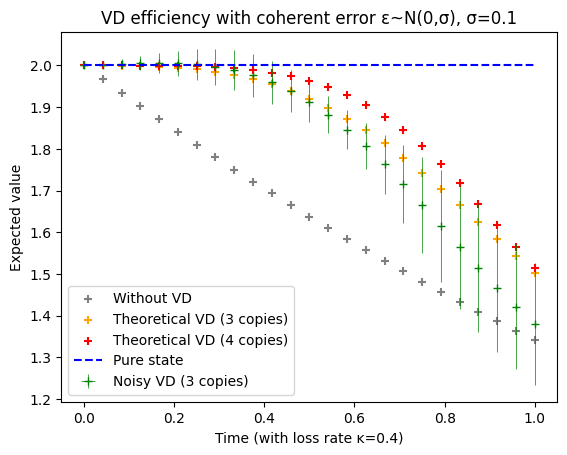

In [12]:
#remove extreme points ?
extr_max, extr_min = n+1, n-2
result_corr = result #[:, np.all(np.logical_and(result<extr_max, result>extr_min),0)]

plt.errorbar(t_list, np.abs(result_corr.mean(1)), result_corr.std(1), np.zeros_like(t_list), 
                barsabove=True, elinewidth=.5,fmt='+',label="Noisy VD (3 copies)", c='g')
plt.scatter(t_list, np.abs(result_withoutVD), label="Without VD", marker='+', c="gray")
plt.scatter(t_list, np.abs(result_th_3), label="Theoretical VD (3 copies)", marker='+', c='orange')
plt.scatter(t_list, np.abs(result_th_4), label="Theoretical VD (4 copies)", marker='+', c='red')
plt.plot(t_list,np.full(t_list.shape,n), linestyle="--", label='Pure state', c='b')
plt.title(f"VD efficiency with coherent error ε~N(0,σ), σ={eps_std}")
plt.xlabel(f"Time (with loss rate ĸ={kappa})")
plt.ylabel("Expected value")
plt.legend()

In [10]:
a = np.array([[2, 4, 1],[3, 1, -2]])
a[:,np.all(a>0, 0)]

array([[2, 4],
       [3, 1]])